In [82]:
import numpy as np
import cv2
import tensorflow as tf;
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.3.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [35]:
from google.colab import files

content_img = files.upload()

Saving CONTENT.jpg to CONTENT.jpg


In [36]:
from google.colab import files
styleImage = files.upload()

Saving STYLE.jpg to STYLE.jpg


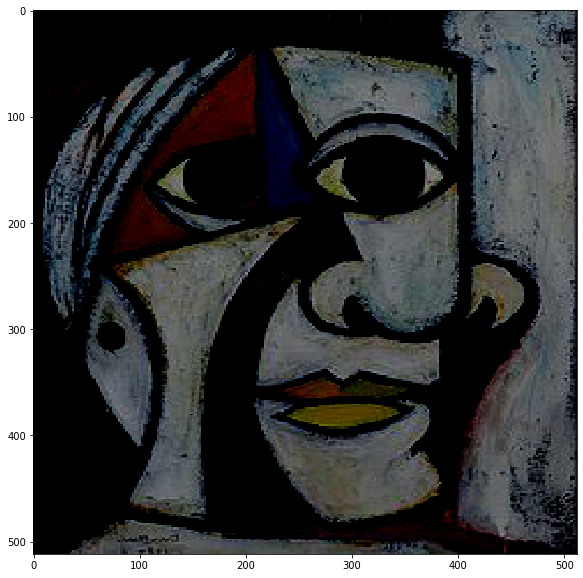

In [65]:
def get_image(imgpath):
    w=512
    h=512
    loaded_img = tf.keras.preprocessing.image.load_img(imgpath,target_size=(w,h))
   
    image = tf.keras.applications.vgg19.preprocess_input(tf.keras.preprocessing.image.img_to_array(loaded_img))
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image , axis = 0)
    return image
def imgshow(image):
    image[:,:,0]  *=64/255.0
    image[:,:,1] *=128/255.0
    image[:,:,2] *=192/255.0
    image = image[:,:,::-1]
    image = np.clip(image,0,255).astype('uint8')
    img=np.squeeze(image)
    plt.figure(figsize = (50,10))
    plt.imshow(img, interpolation='nearest')
styleImage = get_image("/content/STYLE.jpg")
contentImage = get_image("/content/CONTENT.jpg")
imgshow(styleImage)


In [38]:
from tensorflow.keras.applications.vgg19 import VGG19

# Layer Extraction From VGG Model 

In [10]:
baseModel = VGG19(weights='imagenet',include_top=False,pooling='Max');
baseModel.trainable = False;
contentImageLayers = ['block5_conv2']
styleImageLayers = ["block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1"]
baseModel.get_layer(contentImageLayers[0])
print(baseModel.input)

80142336/80134624 [==============================] - 1s 0us/step
Tensor("input_1:0", shape=(None, None, None, 3), dtype=float32)


#Model Prep

In [11]:
contentModel = Model(inputs = baseModel.input,outputs = baseModel.get_layer(contentImageLayers[0]).output) 

In [12]:
styleModel = [Model(inputs = baseModel.input , outputs = baseModel.get_layer(Layer).output) for Layer in styleImageLayers]

# Content Loss

In [13]:
def customLoss(model,inputImage,outputImage):
  val = tf.reduce_mean((model(inputImage) - model(outputImage))**2)
  return val;

# GRAM Matrix ( For Style Loss)

In [14]:
def gramMatrix(inputImage):
  channels=int(inputImage.shape[-1])
  a=tf.reshape(inputImage,[-1,channels])
  n=tf.shape(a)[0]
  gram=tf.matmul(a,a,transpose_a=True)
  return(gram/tf.cast(n,tf.float32))

# Style Loss

In [15]:
def styleLoss(model,inputImage,generated):
  error = 0
  for styleModels in model:
    styleVal = styleModels(inputImage);
    generatedVal = styleModels(generated)
    val = tf.reduce_mean((gramMatrix(styleVal) - gramMatrix(generatedVal))**2);
    error = error + val*1/len(model);
  return error;

# Training the Initial Image with Content and Style Images

In [78]:
def runFunction(contentImage,styleImage):
  ## Calculate loss for content image
  ## Calculate loss for style image
  ## update the initial image by the error from the losses calculated
  ## repeat the process
  contentGenerated = tf.Variable(contentImage,dtype = tf.float32);
  optimizer = tf.keras.optimizers.Adam(learning_rate = 10)
  maxImage = contentGenerated;
  maxCost = 1e12

  ## Weighted Loss calcualtion
  for i in range(0,500):
    print('Iteration : ' + str(i))
    with tf.GradientTape() as tape:
      contentLossVal = customLoss(contentModel,contentImage,contentGenerated)
      styleLossVal = styleLoss(styleModel , styleImage , contentGenerated)
      cost = contentLossVal * 40 + styleLossVal * 1000;
      gradient = tape.gradient(cost , contentGenerated);
      optimizer.apply_gradients([(gradient,contentGenerated)])
      print(cost)
      if(cost < maxCost):
        maxCost = cost;
        maxImage = contentGenerated.numpy();
  return maxImage,contentGenerated.numpy();

In [79]:
img,imgVal = runFunction(contentImage,styleImage)

Iteration : 0
tf.Tensor(21003690000000.0, shape=(), dtype=float32)
Iteration : 1
tf.Tensor(10719777000000.0, shape=(), dtype=float32)
Iteration : 2
tf.Tensor(8785349000000.0, shape=(), dtype=float32)
Iteration : 3
tf.Tensor(7155209500000.0, shape=(), dtype=float32)
Iteration : 4
tf.Tensor(6047760000000.0, shape=(), dtype=float32)
Iteration : 5
tf.Tensor(5044441000000.0, shape=(), dtype=float32)
Iteration : 6
tf.Tensor(4279846600000.0, shape=(), dtype=float32)
Iteration : 7
tf.Tensor(3797754000000.0, shape=(), dtype=float32)
Iteration : 8
tf.Tensor(3369958000000.0, shape=(), dtype=float32)
Iteration : 9
tf.Tensor(3017206000000.0, shape=(), dtype=float32)
Iteration : 10
tf.Tensor(2721595500000.0, shape=(), dtype=float32)
Iteration : 11
tf.Tensor(2463378700000.0, shape=(), dtype=float32)
Iteration : 12
tf.Tensor(2237066400000.0, shape=(), dtype=float32)
Iteration : 13
tf.Tensor(2044856200000.0, shape=(), dtype=float32)
Iteration : 14
tf.Tensor(1870471400000.0, shape=(), dtype=float32)
Ite

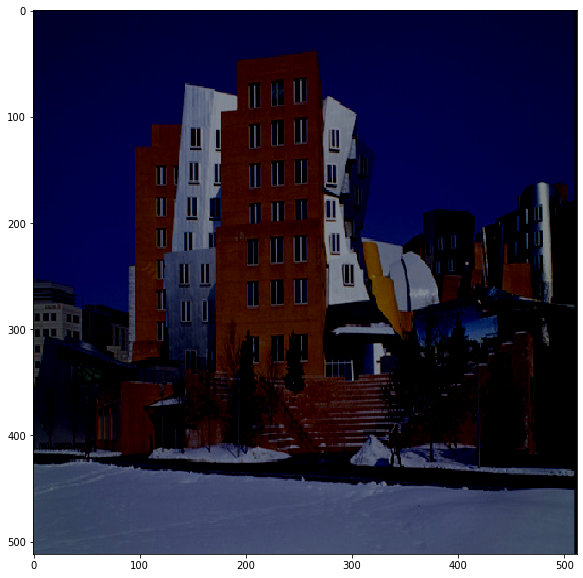

In [80]:
## Original Image

imgshow(contentImage)

# Result Image

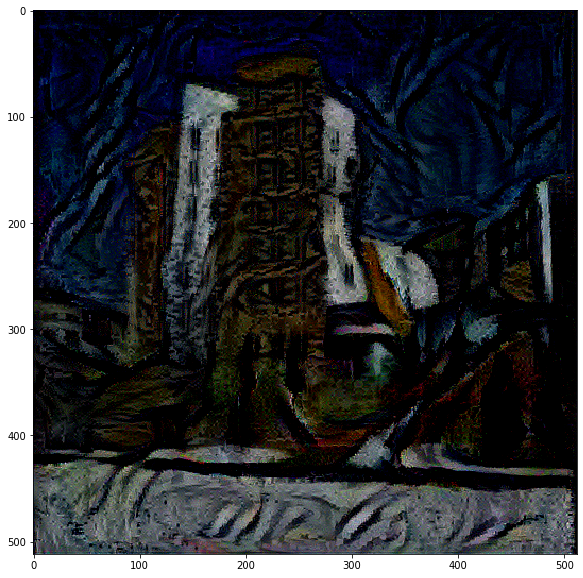

In [81]:
imgshow(imgVal)